In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
import featuristic as ft
import numpy as np

np.random.seed(8888)

print(ft.__version__)

1.0.0


### Load the Data

In [2]:
X, y = ft.fetch_cars_dataset()

X.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,307.0,8,130.0,3504,12.0,70,1
1,350.0,8,165.0,3693,11.5,70,1
2,318.0,8,150.0,3436,11.0,70,1
3,304.0,8,150.0,3433,12.0,70,1
4,302.0,8,140.0,3449,10.5,70,1


In [3]:
y.head()

0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64

### Genetic Feature Synthesis

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

synth = ft.GeneticFeatureSynthesis(
    num_features=5,
    population_size=200,
    max_generations=100,
    early_termination_iters=25,
    parsimony_coefficient=0.025,
    n_jobs=-1,
)
synth.fit(X_train, y_train)

None

Creating new features...:  27%|████▎           | 27/100 [00:12<00:33,  2.20it/s]


### View the Synthesised Features and Their Formulas

In [5]:
generated_features = synth.transform(X_train)

generated_features.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,feature_0,feature_1,feature_3,feature_2,feature_4
0,89.0,4,62.0,2050,17.3,81,3,0.673279,-0.009878,0.566434,-0.917052,0.536626
1,318.0,8,150.0,4077,14.0,72,1,0.133744,-0.002208,0.324324,-0.226914,0.318668
2,383.0,8,170.0,3563,10.0,70,1,0.144654,-0.002456,0.291667,-0.183216,0.287549
3,260.0,8,110.0,4060,19.0,77,1,0.153605,-0.002371,0.411765,-0.295020,0.400227
4,318.0,8,140.0,4080,13.7,78,1,0.156848,-0.002390,0.357798,-0.245131,0.350213


In [6]:
info = synth.get_feature_info()
info

,name,formula,fitness
0,feature_0,(-(((model_year / (weight + cylinders)) + sin(...,-0.861120
1,feature_1,-((model_year / (weight + cylinders))),-0.855109
2,feature_3,abs(abs(-(-((model_year / (model_year + horsep...,-0.829949
3,feature_2,(-(model_year) / (displacement - cos(horsepowe...,-0.831506
4,feature_4,sin(abs((model_year / (model_year + horsepower...,-0.827386


### Feature Selection

In [15]:
def objective_function(X, y):
    model = LinearRegression()
    scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
    return scores.mean() * -1

In [8]:
selector = ft.GeneticFeatureSelector(
    objective_function,
    population_size=200,
    max_generations=100,
    early_termination_iters=25,
    n_jobs=-1,
)

selector.fit(generated_features, y_train)

selected_features = selector.transform(generated_features)

Optimising feature selection...:  28%|██▌      | 28/100 [00:05<00:13,  5.22it/s]


### View the Selected Features

In [9]:
selected_features.head()

,displacement,horsepower,weight,origin,feature_0,feature_1,feature_3,feature_2
0,89.0,62.0,2050,3,0.673279,-0.009878,0.566434,-0.917052
1,318.0,150.0,4077,1,0.133744,-0.002208,0.324324,-0.226914
2,383.0,170.0,3563,1,0.144654,-0.002456,0.291667,-0.183216
3,260.0,110.0,4060,1,0.153605,-0.002371,0.411765,-0.295020
4,318.0,140.0,4080,1,0.156848,-0.002390,0.357798,-0.245131


### Compare New Features to Original Features

In [10]:
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)
original_mae = mean_absolute_error(y_test, preds)
original_mae

2.5888868138669303

In [11]:
model = LinearRegression()
model.fit(selected_features, y_train)
test_features = selector.transform(synth.transform(X_test))
preds = model.predict(test_features)
featuristic_mae = mean_absolute_error(y_test, preds)
featuristic_mae

2.1729482398016042

In [12]:
print(f"Original MAE: {original_mae}")
print(f"Featuristic MAE: {featuristic_mae}")
print(f"Improvement: {round((1 - (featuristic_mae / original_mae))* 100, 1)}%")

Original MAE: 2.5888868138669303
Featuristic MAE: 2.1729482398016042
Improvement: 16.1%


### View the History of the Genetic Algorithms

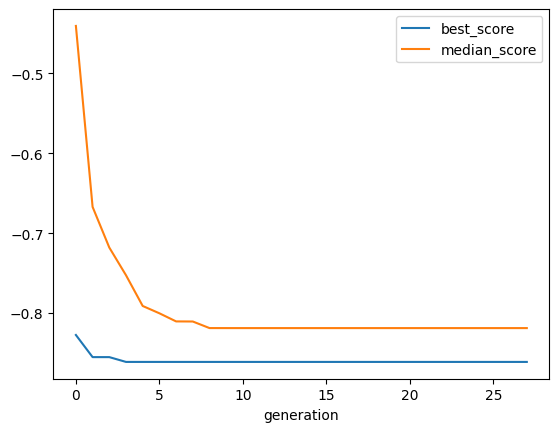

In [13]:
synth.plot_history()

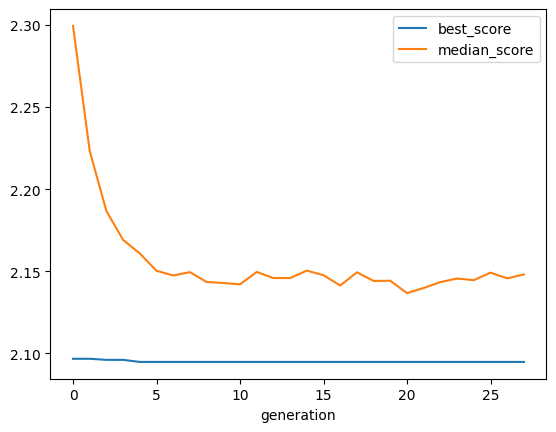

In [14]:
selector.plot_history()